In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import xarray as xr

import scipy.stats as stats

In [ ]:
def mask_cruts(data):
    eu = xr.concat([data.sel(lon = slice(180,360), lat = slice(20,80)),data.sel(lon = slice(0,180), lat = slice(20,80))], dim = 'lon')
    eu.coords['lon'] = (eu.coords['lon'] + 180) % 360 - 180
    eu = eu.sortby(eu.lon)

    eu = eu.sel(time=is_jja(eu['time.month']))
    dt = eu.groupby('time.year').mean()
    return dt.sel(lat = slice(35,71.88), lon = slice(-15,45.94))

def is_jja(month):
    return (month >= 5) & (month <= 8)

def runningMean(x,N):
    y = np.zeros((len(x),))
    for ctr in np.arange(N,len(x)-N,1):
         y[ctr] = np.mean(x[(ctr-N):(ctr+N)])
    return y[N:-N]

def area_weighting(da):
    weights = np.cos(np.deg2rad(da.lat))  # latitudes in degree north
    #weights = coslat / coslat.sum()  # normalise weights so they sum to 1
    weights.name = "weights"
    return weights

def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    result = ((ds * month_length).resample(time='QS-DEC').sum() / 
              month_length.where(ds.notnull()).resample(time='QS-DEC').sum())
    return result

In [ ]:
cruts = xr.open_dataset('/.../cru_ts4.05.1901.2020.grid25x25.dtr.nc').sel(time=slice('1900-01-01','2020-12-31'))
cruts = cruts.sel(time=is_jja(cruts['time.month']))
h_sea = season_mean(cruts.stn)
mask = ~np.isnan(h_sea.where(h_sea>0)).all(axis=0)

weights = area_weighting(cruts)

dt = cruts.where(mask).groupby('time.year').mean()
eu = xr.concat([dt.sel(lon = slice(360-12,360), lat = slice(35,70)),dt.sel(lon = slice(-10,35), lat = slice(35,70))], dim = 'lon')

deurope = eu.weighted(weights).mean(('lon','lat')).dtr.values
dglobe = cruts.where(mask).weighted(weights).mean(('lon','lat')).dtr.groupby('time.year').mean().values

In [ ]:
aodobs = xr.open_dataset('/data/MACv2-masked.nc').sel(time = slice('1850-12-31','2020-12-31'),lat = slice(35.12,69.89), lon = slice(-10.40,34.12))
aodhad = xr.open_dataset('/.../od550aer_day_HadGEM3-GC31-LL_r1_1850101-20141230-Europe.nc').sel(lat = slice(35.12,71.88), lon = slice(-10,35)).groupby('time.year').mean('time')
aodcan = xr.open_dataset('/.../od550aer_day_CanESM5_r1_18500101-20141231-Europe.nc').sel(lat = slice(35.12,71.16), lon = slice(-10, 35)).groupby('time.year').mean('time')

In [ ]:
aodobsanomearly = aodobs.aod_ann - aodobs.aod_ann[0]
aodhadanomearly = aodhad.od550aer - aodhad.od550aer[0]
aodcananomearly = aodcan.od550aer - aodcan.od550aer[0]

aodobsanom = aodobs.aod_ann - aodobs.aod_ann[-80:].mean(('time'))
aodhadanom = aodhad.od550aer - aodhad.od550aer[-80:].mean(('year'))
aodcananom = aodcan.od550aer - aodcan.od550aer[-80:].mean(('year'))

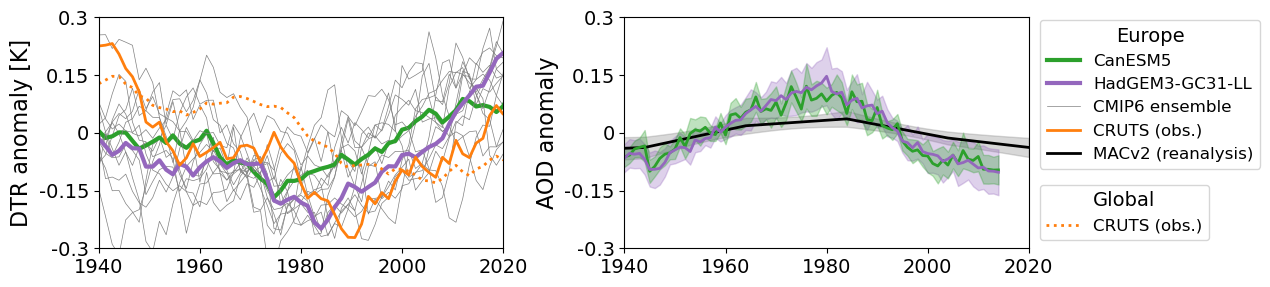

In [ ]:
fig = plt.figure(figsize=(12, 3), facecolor = 'white')
spec = gridspec.GridSpec(ncols=2, nrows=1,
                             width_ratios=[1 for i in range(2)], wspace=0.3,
                             hspace=0.4, height_ratios=[1 for i in range(1)])

mmm = np.zeros((6,121))
ax = fig.add_subplot(spec[0,0])
f = np.load('/data/CanESM5-dtr-hist-europe-long.npy', allow_pickle = True)
mmm = (f.transpose() - f.transpose()[-80:,:].mean(axis = 0))[91:]
ax.plot(np.apply_along_axis(runningMean, 0, mmm, 5), color = 'grey', linestyle = '-', linewidth = 0.5)
ax.plot(runningMean((f.transpose().mean(axis = 1)-f.transpose().mean(axis = 1)[-80:].mean())[91:],5), color = 'tab:green', linestyle = '-', linewidth = 3, label = 'CanESM5')

f = np.load('/data/HadGEM3-GC31-LL-dtr-hist-europe-long.npy', allow_pickle = True)
mmm = (f.transpose() - f.transpose()[-80:,:].mean(axis = 0))[91:]
ax.plot(np.apply_along_axis(runningMean, 0, mmm, 5), color = 'grey', linestyle = '-', linewidth = 0.5)
ax.plot(runningMean((f.transpose().mean(axis = 1)-f.transpose().mean(axis = 1)[-80:].mean())[91:],5), color = 'tab:purple', linestyle = '-', linewidth = 3, label = 'HadGEM3-GC31-LL')

ax.plot(runningMean((deurope - np.mean(deurope[-80:]))[40:], 5), color = 'tab:orange', label = 'CRUTS (obs.)', linewidth = 2)
ax.plot(runningMean((dglobe - np.mean(dglobe[-80:]))[40:], 5), color = 'tab:orange', label = 'CRUTS (obs.)', linewidth = 2, linestyle = ':')
ax.plot(np.apply_along_axis(runningMean, 0, mmm[0], 5), color = 'grey', linestyle = '-', linewidth = 0.5, label = 'CMIP6 ensemble')
# ax.set_title('Obs/ALL')
ax.set_ylim([-0.3,0.3])
ax.set_xlim(0,60)
# ax.legend(bbox_to_anchor=(3.1, 0.9), title = 'Data', fontsize = 14, title_fontsize = 16)
ax.set_xticks([0,15,30,45,60])
ax.set_xticklabels([1940,1960,1980,2000,2020], fontsize = 14)
ax.set_yticks([-0.3,-0.15,0,0.15,0.3])
ax.set_yticklabels([-0.3,-0.15,0,0.15,0.3], fontsize = 14)
ax.set_ylabel('DTR anomaly [K]', fontsize = 16)

h,la = ax.get_legend_handles_labels()

# plt.tight_layout()

obs = aodobsanom.mean(('lat','lon')).values[:,0]
obsstd = aodobsanom.std(('lat','lon')).values[:,0]

had = aodhadanom.mean(('lat','lon')).values#[110:]
hadstd = aodhadanom.std(('lat','lon')).values#[110:]6
can = aodcananom.mean(('lat','lon')).values#[110:]
canstd = aodcananom.std(('lat','lon')).values#[110:]

ax = fig.add_subplot(spec[0,1])

ax.plot(aodobsanom.mean(('lat','lon')).values, color = 'black', linewidth = 2, label = 'MACv2 (reanalysis)')
ax.plot(aodcananom.mean(('lat','lon')).values, color = 'tab:green', linewidth = 2)
ax.plot(aodhadanom.mean(('lat','lon')).values, color = 'tab:purple', linewidth = 2)
ax.fill_between(np.linspace(0,170,171),obs+obsstd, obs-obsstd, color = 'grey', alpha = 0.3)
ax.fill_between(np.linspace(0,164,165), had + hadstd, had-hadstd, color = 'tab:purple', alpha = 0.3)
ax.fill_between(np.linspace(0,164,165), can + canstd, can-canstd, color = 'tab:green', alpha = 0.3)
h1,la1 = ax.get_legend_handles_labels()
fig.legend([h[0],h[1],h[4],h[2],h1[0]],[la[0],la[1],la[4],la[2],la1[0]], bbox_to_anchor=(1.1, 0.9), title = 'Europe', fontsize = 12, title_fontsize = 14)
fig.legend([h[3]],[la[3]], bbox_to_anchor=(1.057, 0.35), title = 'Global', fontsize = 12, title_fontsize = 14)
ax.set_ylim([-0.3,0.3])
ax.set_xlim(90,170)
ax.set_xticks([90,110,130,150,170])
ax.set_xticklabels([1940,1960,1980,2000,2020], fontsize = 14)
ax.set_yticks([-0.3,-0.15,0,0.15,0.3])
ax.set_yticklabels([-0.3,-0.15,0,0.15,0.3], fontsize = 14)
ax.set_ylabel('AOD anomaly', fontsize = 16)
plt.savefig('/home/s2135337/scratch/final/dtr-aod-timeseries.png', bbox_inches = 'tight')